## Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [3]:
import warnings
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [4]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [5]:
from asl_utils import test_features_tryit
# Added df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x'] #Difference in right hand X values and nose X value
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y'] #Difference in left hand Y value and nose Y value
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x'] #Difference in left hand X value and nose X value
asl.df.head() #Added new features in frame dictionary
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [6]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [7]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [8]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [9]:
df_means = asl.df.groupby('speaker').mean()
df_means

left-x      left-y     right-x     right-y      nose-x  \
speaker                                                               
man-1    206.248203  218.679449  155.464350  150.371031  175.031756   
woman-1  164.661438  161.271242  151.017865  117.332462  162.655120   
woman-2  183.214509  176.527232  156.866295  119.835714  170.318973   

            nose-y    grnd-ry    grnd-rx     grnd-ly    grnd-lx  
speaker                                                          
man-1    61.642600  88.728430 -19.567406  157.036848  31.216447  
woman-1  57.245098  60.087364 -11.637255  104.026144   2.006318  
woman-2  58.022098  61.813616 -13.452679  118.505134  12.895536

To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [10]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [11]:
from asl_utils import test_std_tryit
# Created a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


left-x     left-y    right-x    right-y    nose-x    nose-y  \
speaker                                                                   
man-1    15.154425  36.328485  18.901917  54.902340  6.654573  5.520045   
woman-1  17.573442  26.594521  16.459943  34.667787  3.549392  3.538330   
woman-2  15.388711  28.825025  14.890288  39.649111  4.099760  3.416167   

           grnd-ry    grnd-rx    grnd-ly    grnd-lx  left-x-mean  
speaker                                                           
man-1    53.487999  20.269032  36.572749  15.080360          0.0  
woman-1  33.972660  16.764706  27.117393  17.328941          0.0  
woman-2  39.128572  16.191324  29.320655  15.050938          0.0

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [12]:
# Added features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
feature_pos = ['right-x', 'right-y', 'left-x', 'left-y']
#Normalizing Carresian Coordinates
for feature_norm, root_feature in zip(features_norm,feature_pos):
    root_feature_mean = asl.df['speaker'].map(df_means[root_feature]) #Calculating root mean i.e. Xmean
    root_feature_std = asl.df['speaker'].map(df_std[root_feature]) #Calculating root standard deviation i.e. Xstd
    asl.df[feature_norm] = (asl.df[root_feature] - root_feature_mean)/root_feature_std #Z score scaling

In [13]:
# Added features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

grnd_rx, grnd_ry = asl.df['grnd-rx'], asl.df['grnd-ry'] #Ground rx and ry is diff b/w righthand X value and nose X value and right hand Y value and nose Y value respectively.
grnd_lx, grnd_ly = asl.df['grnd-lx'], asl.df['grnd-ly'] #Ground lx and ly is diff b/w lefthand X value and nose x value and lefthand Y value and nose Y value respectively.

asl.df['polar-rr'] = np.hypot(grnd_rx, grnd_ry) #Calculating polar right radius with righthand and nose grounded X and Y value
asl.df['polar-lr'] = np.hypot(grnd_lx, grnd_ly) #Calculating polar left radius with lefthand and nose grounded X and Y value
asl.df['polar-rtheta'] = np.arctan2(grnd_rx, grnd_ry) #Calculating polar-rtheta
asl.df['polar-ltheta'] = np.arctan2(grnd_lx, grnd_ly) #Calculating polar-ltheta

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta'] #addded to feature-polar list

In [14]:
# Added features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
# Difference in values between one frame and next frame
asl.df['delta-rx'] = asl.df['right-x'].fillna(0).diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].fillna(0).diff().fillna(0)
asl.df['delta-lx'] = asl.df['left-x'].fillna(0).diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].fillna(0).diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly'] # added to feature delta list

In [15]:
# Added features of your own design, which may be a combination of the above or something else
# As suggested above, Normalizing Grounded feature
features_norm_grnd = ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']
features_grnd = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']

df_std = asl.df.groupby('speaker').std()
df_mean = asl.df.groupby('speaker').mean()

for feature_norm_grnd, root_feature in zip(features_norm_grnd, features_grnd):
    asl.df[feature_norm_grnd] = (asl.df[root_feature] - asl.df['speaker'].map(df_means[root_feature])) / asl.df['speaker'].map(df_std[root_feature])
    
# Delta values for normalized Ground features
feature_delta_norm_grnd = ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly']
asl.df[feature_delta_norm_grnd] = asl.df[features_norm_grnd].fillna(0).diff().fillna(0)

#Normalizing Polar coordinates
features_norm_polar = ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']
features_plr = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

df_std_polar = asl.df.groupby('speaker').std()
df_mean_polar = asl.df.groupby('speaker').mean()

for feature_norm_polar, root_feature_polar in zip(features_norm_polar,features_plr):
    asl.df[feature_norm_polar] = (asl.df[root_feature_polar] - asl.df['speaker'].map(df_mean_polar[root_feature_polar])) / asl.df['speaker'].map(df_std_polar[root_feature_polar])

# Delta values for normalized Polar features
feature_delta_norm_polar = ['delta-norm-polar-rr', 'delta-norm-polar-rtheta', 'delta-norm-polar-lr', 'delta-norm-polar-ltheta']
asl.df[feature_delta_norm_polar] = asl.df[features_norm_polar].fillna(0).diff().fillna(0)

# Defines a list named 'features_custom' for building the training set
features_custom = features_norm_grnd + feature_delta_norm_grnd + features_norm_polar + feature_delta_norm_polar

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** I choose to normalize Ground feature (features_norm_grnd) i.e. difference in hand and nose co-ordinates. We generally normalize any feature if we want to get the data on the same scale, if the scales for different features are widely different, this may have knock-on model ability to learn. It is good to standardize features values implicitly weights all features equally in their representation. As, Ground features (features-grnd) is difference in hand and nose co-ordinates which might vary due to different heights of different speakers.
So, normalizing the same would be better option.

I also choose to take delta value of normalized ground features and advantages of using delta are already highlights in Thad's lecture.

Apart from normalizing Ground features i also choose to normalize Polar coordinates and took delta value of normalized polar coordinates value.


<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [16]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.020s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [17]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.113812743319


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [18]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

### Feature Ground

In [19]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028621


### Feature Normalized Ground

In [20]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_norm_grnd) # Replacing with Feature Normalized Ground
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 0.33504838 -0.23255978 -0.44649782 -1.65918442]
variance =  [ 0.03611042  0.00449338  0.00155457  0.00676528]

hidden state #1
mean =  [ 0.34911323  0.01768657 -0.0983817  -0.61135222]
variance =  [ 0.04192261  0.05595178  0.03091993  0.16873738]

hidden state #2
mean =  [ 0.99416385 -0.01517655 -1.2245362  -1.32713153]
variance =  [ 0.09675956  0.00738464  0.04416411  0.10880308]

logL = 52.47794393444834


### Delta values of Feature Normalized Ground

In [21]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, feature_delta_norm_grnd) # Replacing with delta Feature Normalized Ground
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 0.14640761  0.00171612 -0.0326769  -0.34164792]
variance =  [ 0.02453163  0.00402719  0.03453227  0.00978826]

hidden state #1
mean =  [-0.00440173  0.00792025 -0.0071367  -0.00521873]
variance =  [ 0.00063456  0.00217138  0.02233351  0.00422216]

hidden state #2
mean =  [-0.04872786  0.08848788  0.06965579  0.0791568 ]
variance =  [ 0.08367705  0.01389099  0.00689296  0.01487319]

logL = 183.1023673331571


### Polar Features

In [22]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_polar) # Replacing with Polar Features
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 56.19235087  -0.16348589  71.60640024   0.0958256 ]
variance =  [  5.16348282e+01   4.22849414e-03   1.74535632e+01   1.18341913e-03]

hidden state #1
mean =  [  8.81313612e+01   8.31771967e-03   1.09304329e+02   1.18434797e-01]
variance =  [  2.06973439e+01   5.41190376e-03   1.41647879e+02   1.92144403e-03]

hidden state #2
mean =  [  6.05010053e+01  -9.31757873e-02   9.14166393e+01   2.57297227e-02]
variance =  [  6.15523307e+01   3.56540651e-03   1.30626433e+02   1.81995354e-03]

logL = -179.21522065553515


### Normalized Polar Features

In [23]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_norm_polar) # Replacing with Normalized polar features
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [-0.26057161  0.48991141 -1.754827   -0.33867755]
variance =  [ 0.02935861  0.13162366  0.02613229  0.05371838]

hidden state #1
mean =  [-0.00892579  0.57001662 -0.85620942 -0.25997993]
variance =  [ 0.02685728  0.0121504   0.02703956  0.04334482]

hidden state #2
mean =  [-0.43567333  0.37225216 -0.32965362 -0.29811062]
variance =  [ 0.01187406  0.05490274  0.25105733  0.01524059]

logL = 38.855694231619665


### Delta values of Normalized Polar Features

In [24]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, feature_delta_norm_polar) #Replacing with delta values of Norm Polar Features
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [-0.00232987  0.07113751 -0.32068122 -0.00507313]
variance =  [ 0.00537749  0.00824713  0.02208024  0.01820034]

hidden state #1
mean =  [ 0.11513179 -0.00034274  0.08839649  0.06034013]
variance =  [ 0.01465258  0.01919955  0.02121595  0.03455639]

hidden state #2
mean =  [ -3.30017104e-03  -7.36061325e-03  -7.05049916e-12   6.04805115e-12]
variance =  [ 0.00062308  0.00798317  0.00047833  0.00047833]

logL = 243.82337547305605


### Custom Features

In [25]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_custom) # Replacing with Custom features
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [  9.94163854e-01  -1.51765543e-02  -1.22453620e+00  -1.32713153e+00
   1.15118143e-01  -2.80436736e-02   9.37304300e-69  -8.65854150e-02
  -1.49255689e-01   8.23253486e-01  -1.51836159e+00  -5.62843183e-01
  -3.36367989e-02   6.15597431e-02  -9.16289234e-02   1.97132488e-02]
variance =  [ 0.09675956  0.00738464  0.04416411  0.10880308  0.05127278  0.00482383
  0.03307949  0.0327113   0.00940745  0.03196555  0.12150031  0.04219313
  0.00622097  0.0173876   0.03799468  0.02153849]

hidden state #1
mean =  [ 0.34862479  0.01819214 -0.09765693 -0.6093146  -0.0023046   0.05381673
  0.01021486 -0.07155439 -0.12825766  0.4686104  -0.72890661 -0.20473875
  0.05938156  0.00902149 -0.07612701  0.01455125]
variance =  [ 0.04189889  0.0559827   0.0307832   0.16746048  0.01543214  0.00619889
  0.02744574  0.04325739  0.06677642  0.04431777  0.19159872  0.02200165
  0.00776905  0.00640665  0.05084991  0.01909646]

hidden s

##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [26]:
%matplotlib inline

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028621
Model Components are =  3


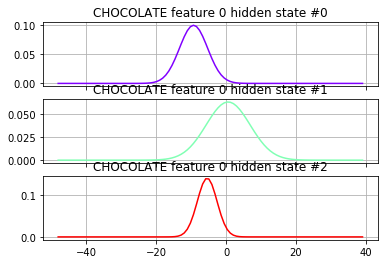

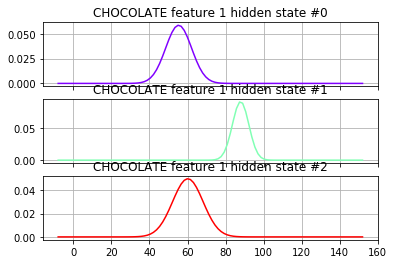

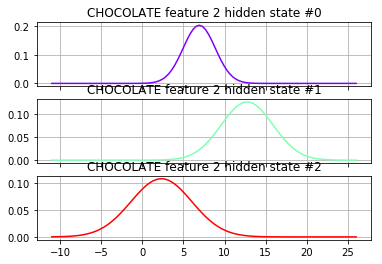

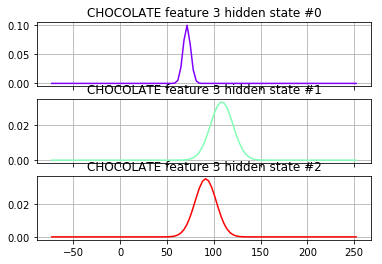

In [27]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground)

show_model_stats(my_testword, model)
print("logL = {}".format(logL))     
print("Model Components are = ",model.n_components)
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [28]:
from my_model_selectors import SelectorConstant

#Experimenting with different Feature sets and different words
for feature in [features_ground,features_norm_grnd,feature_delta_norm_grnd,features_polar,features_norm_polar,feature_delta_norm_polar]:
    print("For Feature: {}".format(', '.join(feature)))
    for word in ['VEGETABLE', 'BOOK', 'CHOCOLATE']:
        training = asl.build_training(feature) 
        model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
        print("\tNumber of states trained in model for {} is {}".format(word, model.n_components))
    print("\n")

For Feature: grnd-rx, grnd-ry, grnd-lx, grnd-ly
	Number of states trained in model for VEGETABLE is 3
	Number of states trained in model for BOOK is 3
	Number of states trained in model for CHOCOLATE is 3


For Feature: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
	Number of states trained in model for VEGETABLE is 3
	Number of states trained in model for BOOK is 3
	Number of states trained in model for CHOCOLATE is 3


For Feature: delta-norm-grnd-rx, delta-norm-grnd-ry, delta-norm-grnd-lx, delta-norm-grnd-ly
	Number of states trained in model for VEGETABLE is 3
	Number of states trained in model for BOOK is 3
	Number of states trained in model for CHOCOLATE is 3


For Feature: polar-rr, polar-rtheta, polar-lr, polar-ltheta
	Number of states trained in model for VEGETABLE is 3
	Number of states trained in model for BOOK is 3
	Number of states trained in model for CHOCOLATE is 3


For Feature: norm-polar-rr, norm-polar-rtheta, norm-polar-lr, norm-polar-ltheta
	Number of state

##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [29]:
from sklearn.model_selection import KFold

# Experimented with different feature sets
for feature in [features_ground,features_norm_grnd,feature_delta_norm_grnd,features_polar,features_norm_polar,feature_delta_norm_polar]:
    print("For Feature: {}".format(', '.join(feature)))
    for word in ['VEGETABLE', 'BOOK', 'CHOCOLATE']:
        training = asl.build_training(feature) 
        #word = 'VEGETABLE' # Experiment here with different words
        word_sequences = training.get_word_sequences(word)
        split_method = KFold()
        for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
            print("\tTrain fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds
        print(" ")

For Feature: grnd-rx, grnd-ry, grnd-lx, grnd-ly
	Train fold indices:[2 3 4 5] Test fold indices:[0 1]
	Train fold indices:[0 1 4 5] Test fold indices:[2 3]
	Train fold indices:[0 1 2 3] Test fold indices:[4 5]
 
	Train fold indices:[ 6  7  8  9 10 11 12 13 14 15 16 17] Test fold indices:[0 1 2 3 4 5]
	Train fold indices:[ 0  1  2  3  4  5 12 13 14 15 16 17] Test fold indices:[ 6  7  8  9 10 11]
	Train fold indices:[ 0  1  2  3  4  5  6  7  8  9 10 11] Test fold indices:[12 13 14 15 16 17]
 
	Train fold indices:[1 2] Test fold indices:[0]
	Train fold indices:[0 2] Test fold indices:[1]
	Train fold indices:[0 1] Test fold indices:[2]
 
For Feature: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
	Train fold indices:[2 3 4 5] Test fold indices:[0 1]
	Train fold indices:[0 1 4 5] Test fold indices:[2 3]
	Train fold indices:[0 1 2 3] Test fold indices:[4 5]
 
	Train fold indices:[ 6  7  8  9 10 11 12 13 14 15 16 17] Test fold indices:[0 1 2 3 4 5]
	Train fold indices:[ 0  1  2  3  4 

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [30]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [31]:
# Implemented SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

# Experimenting here with different feature sets defined in part 1

for feature in [features_ground,features_norm_grnd,feature_delta_norm_grnd,features_polar,features_norm_polar,feature_delta_norm_polar]:
    print("For Feature: {}".format(', '.join(feature))) 
    training = asl.build_training(features_ground)  
    sequences = training.get_all_sequences()
    #print("Sequences is : ", sequences)
    Xlengths = training.get_all_Xlengths()
    #print("XLength is : ", Xlengths)
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))
    print("\n")

For Feature: grnd-rx, grnd-ry, grnd-lx, grnd-ly
	Training complete for FISH with 5 states with time 0.3571817126020153 seconds
	Training complete for BOOK with 2 states with time 3.976261231850017 seconds
	Training complete for VEGETABLE with 2 states with time 1.5826405989583128 seconds
	Training complete for FUTURE with 2 states with time 3.804834442471533 seconds
	Training complete for JOHN with 3 states with time 39.34290213398242 seconds


For Feature: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
	Training complete for FISH with 5 states with time 0.3571256569758887 seconds
	Training complete for BOOK with 2 states with time 4.022591601603985 seconds
	Training complete for VEGETABLE with 2 states with time 1.5798725563497271 seconds
	Training complete for FUTURE with 2 states with time 3.9798649769974617 seconds
	Training complete for JOHN with 3 states with time 38.22581772131511 seconds


For Feature: delta-norm-grnd-rx, delta-norm-grnd-ry, delta-norm-grnd-lx, delta-no

In [32]:
# Implemented SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

# Experimenting here with different feature sets defined in part 1
for feature in [features_ground,features_norm_grnd,feature_delta_norm_grnd,features_polar,features_norm_polar,feature_delta_norm_polar]:
    print("For Feature: {}".format(', '.join(feature)))
    training = asl.build_training(features_ground)  
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))
    print("\n")

For Feature: grnd-rx, grnd-ry, grnd-lx, grnd-ly
	Training complete for FISH with 3 states with time 0.36641628486995614 seconds
	Training complete for BOOK with 2 states with time 2.043053878930891 seconds
	Training complete for VEGETABLE with 2 states with time 0.7209989112575954 seconds
	Training complete for FUTURE with 2 states with time 2.224375670595066 seconds
	Training complete for JOHN with 2 states with time 20.11720362956231 seconds


For Feature: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
	Training complete for FISH with 3 states with time 0.3588989095996453 seconds
	Training complete for BOOK with 2 states with time 2.0508835077242225 seconds
	Training complete for VEGETABLE with 2 states with time 0.7455200896258702 seconds
	Training complete for FUTURE with 2 states with time 2.213624833116114 seconds
	Training complete for JOHN with 2 states with time 20.959006757466284 seconds


For Feature: delta-norm-grnd-rx, delta-norm-grnd-ry, delta-norm-grnd-lx, delta-

In [33]:
# Implemented SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

# Experiment here with different feature sets defined in part 1
for feature in [features_ground,features_norm_grnd,feature_delta_norm_grnd,features_polar,features_norm_polar,feature_delta_norm_polar]:
    print("For Feature: {}".format(', '.join(feature)))
    training = asl.build_training(features_ground)  
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    for word in words_to_train:
        start = timeit.default_timer()
        model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
        end = timeit.default_timer()-start
        if model is not None:
            print("\tTraining complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        else:
            print("Training failed for {}".format(word))
    print("\n")

For Feature: grnd-rx, grnd-ry, grnd-lx, grnd-ly
	Training complete for FISH with 3 states with time 0.6292315089463045 seconds
	Training complete for BOOK with 15 states with time 4.127965125505398 seconds
	Training complete for VEGETABLE with 15 states with time 3.0427432044396028 seconds
	Training complete for FUTURE with 15 states with time 4.4816342820419095 seconds
	Training complete for JOHN with 15 states with time 21.77293129080317 seconds


For Feature: norm-grnd-rx, norm-grnd-ry, norm-grnd-lx, norm-grnd-ly
	Training complete for FISH with 3 states with time 0.6245954718107214 seconds
	Training complete for BOOK with 15 states with time 4.2904822283927615 seconds
	Training complete for VEGETABLE with 15 states with time 3.1873252702710033 seconds
	Training complete for FUTURE with 15 states with time 4.708627987232035 seconds
	Training complete for JOHN with 15 states with time 23.566579477798427 seconds


For Feature: delta-norm-grnd-rx, delta-norm-grnd-ry, delta-norm-grnd-lx

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** 
**Discriminative information criterion : ** 
Unlike the Bayes Factor criterion, the Discriminant Factor Criterion is the difference between the evidence of the model, given the corresponding data set, and the average over anti-evidences of the model. By choosing the model which maximizes the evidence, and minimize the anti evidences, the result is the best generative model for the correct class and the worst generative model for the competitive classes; this scheme thus selects the most discriminant models, resulting in an improved accuracy in regard to the classiﬁcation task.

** Bayesian information criterion (BIC) ** is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred. It is based on the likelihood function. When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. BIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model.
**Advantages of BIC are :**
It can measure the efficiency of the parameterized model in terms of predicting the data.
It penalizes the complexity of the model where complexity refers to the number of parameters in the model.
**Disadvantages of BIC are :**
The BIC cannot handle complex collections of models


** Cross Validation** is based on the basic idea of not using entire dataset when training the model. Some of the data is removed before training begins. Then when training is done, the removed data is used to test the performance of learned model on "New" data. K-fold cross validation is one way to improve over the holdout method. The data set is divided into k subsets, and the holdout method is repeated k times. Each time, one of the k subsets is used as the test set and the other k-1 subsets are put together to form a training set. Then the average error across all k trials is computed. 
The **advantage of this method is** that it matters less how the data gets divided. Every data point gets to be in a test set exactly once, and gets to be in a training set k-1 times. The variance of the resulting estimate is reduced as k is increased. 
The **disadvantage of this method is** that the training algorithm has to be rerun from scratch k times, which means it takes k times as much computation to make an evaluation. A variant of this method is to randomly divide the data into a test and training set k different times. The advantage of doing this is that you can independently choose how large each test set is and how many trials you average over.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [34]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 58.830s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [35]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [36]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [37]:
# implemented the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

### Ground Feature and Cross Validation model

In [39]:
# Ground Feature and Cross validation model
import my_model_selectors

features = features_ground #Ground feature
model_selector = my_model_selectors.SelectorCV #Cross-validation folds

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorCV'>

**** WER = 0.6573033707865169
Total correct: 61 out of 178
Video  Recognized                                                    Correct
    2: *WHO *BOOK *NEW                                               JOHN WRITE HOMEWORK
    7: JOHN *WHAT GO *HAVE                                           JOHN CAN GO CAN
   12: JOHN *TEACHER *WHAT CAN                                       JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE *NEW *MARY *CAR *TEACHER *CHICAGO *EAT        JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *IX *LOVE IX IX                                        JOHN LIKE IX IX IX
   28: *IX *TELL IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: *IX LIKE *MARY *MARY IX                                       JOHN LIKE IX IX IX
   36: MARY VEGETABLE *YESTERDAY *GO *IX *JOHN                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE

### Ground Feature and Bayesian Information Criterion model

In [40]:
# Ground Feature and BIC model
import my_model_selectors

features = features_ground #Ground feature
model_selector = my_model_selectors.SelectorBIC #BIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.6348314606741573
Total correct: 65 out of 178
Video  Recognized                                                    Correct
    2: *WHO WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *GO1 *HAVE *WHAT                                         JOHN CAN GO CAN
   12: JOHN CAN *CAN CAN                                             JOHN CAN GO CAN
   21: *FRANK *HOMEWORK WONT *TELL *CAR *CAR EAT *TOMORROW           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *TELL *MARY *TELL *LOVE                                  JOHN LIKE IX IX IX
   28: JOHN *TELL *MARY *TELL *LOVE                                  JOHN LIKE IX IX IX
   30: *LIKE LIKE *MARY *MARY IX                                     JOHN LIKE IX IX IX
   36: *WHO VEGETABLE *IX *GIVE *BILL *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: *JANA *BI

### Ground Feature and Discriminative Information Criterion model

In [41]:
# Ground Feature and DIC model
import my_model_selectors

features = features_ground #Ground feature
model_selector = my_model_selectors.SelectorDIC #DIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['grnd-rx', 'grnd-ry', 'grnd-lx', 'grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *CAR *ARRIVE *ARRIVE                           JOHN CAN GO CAN
   12: *IX *WHAT *WHAT *CAR                                          JOHN CAN GO CAN
   21: JOHN *GIVE1 *JOHN *FUTURE *CAR *CAR *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT *VISIT *GIVE *GO *MARY *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO

### Normalized Ground Feature and Cross validation model

In [42]:
# Normalized Ground Feature and Cross validation model
import my_model_selectors

features = features_norm_grnd #Normalized Ground feature
model_selector = my_model_selectors.SelectorCV #Cross-validation folds

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorCV'>

**** WER = 0.6292134831460674
Total correct: 66 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *BUY GO CAN                                    JOHN CAN GO CAN
   12: *WHAT *CAR *CAR *HOUSE                                        JOHN CAN GO CAN
   21: *MARY *NEW *NEW *ANN *HAVE *CAR *ARRIVE *OLD                  JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY *MARY *GO *MARY *LOVE                                   JOHN LIKE IX IX IX
   28: *MARY *MARY *GO *MARY *LOVE                                   JOHN LIKE IX IX IX
   30: JOHN *MARY *LOVE *LOVE *LOVE                                  JOHN LIKE IX IX IX
   36: *IX *PREFER *FUTURE *TELL *LOVE *IX-1P                        MARY VEGETABLE KNOW IX LIKE COR

### Normalized Ground Feature and Bayesian Information Criterion model

In [43]:
# Normalized Ground Feature and BIC model
import my_model_selectors

features = features_norm_grnd #Normalized Ground feature
model_selector = my_model_selectors.SelectorBIC #BIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
    2: *WOMAN WRITE HOMEWORK                                         JOHN WRITE HOMEWORK
    7: JOHN *BUY *JOHN CAN                                           JOHN CAN GO CAN
   12: JOHN *HAVE *CAN *HOUSE                                        JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE *HAVE EAT *HOUSE *CAR *CHICAGO *HOMEWORK      JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *LOVE LIKE *MARY *LIKE *LOVE                                  JOHN LIKE IX IX IX
   28: *LOVE *WOMAN *LOVE *LIKE *LOVE                                JOHN LIKE IX IX IX
   30: *LIKE LIKE *LOVE *BILL IX                                     JOHN LIKE IX IX IX
   36: MARY *WHO *FUTURE *BILL *BILL *LEAVE                          MARY VEGETABLE KNOW IX LIKE CO

### Normalized Ground Feature and Discriminative Information Criterion model

In [44]:
# Normalized Ground Feature and DIC model
import my_model_selectors

features = features_norm_grnd #Normalized Ground feature
model_selector = my_model_selectors.SelectorDIC #DIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.550561797752809
Total correct: 80 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *CAR GO *JOHN                                            JOHN CAN GO CAN
   12: *WHAT *CAR *JOHN *HOUSE                                       JOHN CAN GO CAN
   21: *MARY *NEW *JOHN *ANN *JOHN *CAR *FUTURE *JOHN                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY *MARY IX IX IX                                          JOHN LIKE IX IX IX
   28: *MARY *MARY IX IX IX                                          JOHN LIKE IX IX IX
   30: *IX *MARY *MARY *WOMAN IX                                     JOHN LIKE IX IX IX
   36: *IX *NOT *IX *TELL *LOVE *IX                                  MARY VEGETABLE KNOW IX LIKE COR

### Delta values of Normalized Ground Feature and Cross validation model

In [45]:
# Delta values of Normalized Ground Feature and Cross validation model
import my_model_selectors

features = feature_delta_norm_grnd #Delta values of Normalized Ground feature
model_selector = my_model_selectors.SelectorCV #Cross-validation folds

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorCV'>

**** WER = 0.601123595505618
Total correct: 71 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX HOMEWORK                                             JOHN WRITE HOMEWORK
    7: JOHN *BOY *GIVE1 *TEACHER                                     JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN FISH *KNOW *LOVE *CAR *VISIT *MARY *MARY                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN *CORN *GIRL *GIRL IX                                     JOHN LIKE IX IX IX
   36: MARY *VIDEOTAPE *MARY *LOVE *VIDEOTAPE *MARY                  MARY VEG

### Delta values of Normalized Ground Feature and BIC model

In [46]:
# Delta values of Normalized Ground Feature and BIC model
import my_model_selectors

features = feature_delta_norm_grnd #Delta values of Normalized Ground feature
model_selector = my_model_selectors.SelectorBIC #BIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.5842696629213483
Total correct: 74 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX HOMEWORK                                             JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *GIVE1 *TEACHER                                  JOHN CAN GO CAN
   12: JOHN CAN *VISIT CAN                                           JOHN CAN GO CAN
   21: JOHN FISH *GO1 *BROCCOLI *CAR *VISIT *MARY *WHO               JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   28: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *CORN *SEARCH-FOR IX IX                                  JOHN LIKE IX IX IX
   36: *TOY1 *VIDEOTAPE KNOW *GIVE2 *HERE *JOHN                      MARY V

### Delta values of Normalized Ground Feature and DIC model

In [47]:
# Delta values of Normalized Ground Feature and DIC model
import my_model_selectors

features = feature_delta_norm_grnd #Delta values of Normalized Ground feature
model_selector = my_model_selectors.SelectorDIC #DIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.6179775280898876
Total correct: 68 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX HOMEWORK                                             JOHN WRITE HOMEWORK
    7: JOHN *VISIT *IX *VISIT                                        JOHN CAN GO CAN
   12: JOHN *BOX *GO1 CAN                                            JOHN CAN GO CAN
   21: JOHN *MARY *MARY *MARY *IX *FUTURE *MARY *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *WOMAN IX *JOHN IX                                       JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN *CORN *PUTASIDE IX *WOMAN                                JOHN LIKE IX IX IX
   36: MARY *JOHN *SHOULD *NOT *FUTURE1 *MARY                        MARY V

### Polar Feature and Cross validation model

In [48]:
# Polar Feature and Cross validation model
import my_model_selectors

features = features_polar #Polar features
model_selector = my_model_selectors.SelectorCV #Cross-validation folds

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorCV'>

**** WER = 0.6910112359550562
Total correct: 55 out of 178
Video  Recognized                                                    Correct
    2: *MARY *BROTHER *ARRIVE                                        JOHN WRITE HOMEWORK
    7: JOHN *HAVE GO CAN                                             JOHN CAN GO CAN
   12: JOHN *TEACHER *WHAT CAN                                       JOHN CAN GO CAN
   21: *SHOULD *NEW WONT *MARY *CAR *CAR *VISIT *FUTURE              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK *MARY *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   28: *FRANK *TELL *LOVE *TELL *LOVE                                JOHN LIKE IX IX IX
   30: *SHOULD LIKE *MARY *MARY *MARY                                JOHN LIKE IX IX IX
   36: *SOMETHING-ONE *PREFER *GIRL *GIVE *MARY *JOHN                MARY VEGETABLE KNOW IX LIKE CORN1
   40

### Polar Feature and BIC model

In [49]:
# Polar Feature and BIC model
import my_model_selectors

features = features_polar #Polar feature
model_selector = my_model_selectors.SelectorBIC #BIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.6404494382022472
Total correct: 64 out of 178
Video  Recognized                                                    Correct
    2: *WHO WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *HAVE *JOHN *WHAT                                        JOHN CAN GO CAN
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   21: *FRANK *HOMEWORK WONT *TELL *CAR *CAR EAT *TOMORROW           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *THROW *TELL *THROW *TELL *LOVE                               JOHN LIKE IX IX IX
   28: JOHN *TELL *MARY *TELL *LOVE                                  JOHN LIKE IX IX IX
   30: *LIKE LIKE *MARY *MARY IX                                     JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIRL *GIVE *BILL *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   4

### Polar Feature and DIC model

In [50]:
# Polar Feature and DIC model
import my_model_selectors

features = features_polar #Polar feature
model_selector = my_model_selectors.SelectorDIC #DIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *PREFER *GIVE1 *WHAT *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   4

### Normalized Polar Feature and Cross validation model

In [51]:
# Normalized Polar Feature and Cross validation model
import my_model_selectors

features = features_norm_polar #Normalized Polar features
model_selector = my_model_selectors.SelectorCV #Cross-validation folds

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorCV'>

**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
    2: *WOMAN WRITE *ARRIVE                                          JOHN WRITE HOMEWORK
    7: JOHN *NEW GO *ARRIVE                                          JOHN CAN GO CAN
   12: *IX *CAR *HAVE CAN                                            JOHN CAN GO CAN
   21: *MARY *VIDEOTAPE *NEW *ANN *CAR *CAR *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *MARY *MARY IX IX IX                                          JOHN LIKE IX IX IX
   28: *IX *GO *GO IX IX                                             JOHN LIKE IX IX IX
   30: JOHN *MARY *LOVE *MARY *LOVE                                  JOHN LIKE IX IX IX
   36: MARY VEGETABLE *FUTURE *BILL *MARY *IX-1P                     MARY VEGETABLE KNOW

### Normalized Polar Feature and BIC model

In [52]:
# Normalized Polar Feature and BIC model
import my_model_selectors

features = features_norm_polar #Normalized Polar feature
model_selector = my_model_selectors.SelectorBIC #BIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.6292134831460674
Total correct: 66 out of 178
Video  Recognized                                                    Correct
    2: *MOTHER WRITE HOMEWORK                                        JOHN WRITE HOMEWORK
    7: *SHOULD *PEOPLE *MARY *TOY                                    JOHN CAN GO CAN
   12: JOHN *HAVE *CAR *HOUSE                                        JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE *GIVE1 *IX-1P *CAR *CAR *YESTERDAY *WHO       JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *LOVE LIKE *LOVE *HAVE *LOVE                                  JOHN LIKE IX IX IX
   28: *MARY *MARY *LOVE *LIKE *LOVE                                 JOHN LIKE IX IX IX
   30: *LIKE LIKE IX *SHOOT *SHOOT                                   JOHN LIKE IX IX IX
   36: MARY *NOT *GIRL *GIVE *SHOOT *LIKE                            MARY VEGETABLE KNO

### Normalized Polar Feature and DIC model

In [53]:
#Normalized Polar Feature and DIC model
import my_model_selectors

features = features_norm_polar #Normalized Polar feature
model_selector = my_model_selectors.SelectorDIC #DIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *NEW GO CAN                                    JOHN CAN GO CAN
   12: JOHN *CAR *WHAT *HOUSE                                        JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *ANN *CAR *HOUSE *ARRIVE *YESTERDAY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY *JOHN *JOHN                                  JOHN LIKE IX IX IX
   28: JOHN *JOHN *JOHN *JOHN *JOHN                                  JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *SHOOT                                  JOHN LIKE IX IX IX
   36: *IX *NOT *YESTERDAY *TELL *LOVE *MARY                         MARY VEGETABLE KNO

### Delta values of Normalized Polar Feature and Cross validation model

In [54]:
# Delta values of Normalized Polar Feature and Cross validation model
import my_model_selectors

features = feature_delta_norm_polar #Delta values of Normalized Polar features
model_selector = my_model_selectors.SelectorCV #Cross-validation folds

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['delta-norm-polar-rr', 'delta-norm-polar-rtheta', 'delta-norm-polar-lr', 'delta-norm-polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorCV'>

**** WER = 0.5842696629213483
Total correct: 74 out of 178
Video  Recognized                                                    Correct
    2: JOHN *LOVE *VISIT                                             JOHN WRITE HOMEWORK
    7: JOHN CAN GO *HOUSE                                            JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: JOHN FISH *APPLE *MARY *CAR *FUTURE EAT *MARY                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *LOVE *JOHN IX IX                                        JOHN LIKE IX IX IX
   28: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   30: JOHN *VEGETABLE *PUTASIDE *KNOW IX                            JOHN LIKE IX IX IX
   36: MARY *SOMETHING-ONE *FUTURE *SHOOT *CANDY *IX            

### Delta values of Normalized Polar Feature and BIC model

In [55]:
# Delta values of Normalized Polar Feature and BIC model
import my_model_selectors

features = feature_delta_norm_polar #Delta values of Normalized Polar feature
model_selector = my_model_selectors.SelectorBIC #BIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['delta-norm-polar-rr', 'delta-norm-polar-rtheta', 'delta-norm-polar-lr', 'delta-norm-polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.6404494382022472
Total correct: 64 out of 178
Video  Recognized                                                    Correct
    2: JOHN *JOHN HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN CAN *GIVE *HOUSE                                         JOHN CAN GO CAN
   12: JOHN *BOX *GO1 CAN                                            JOHN CAN GO CAN
   21: JOHN FISH WONT *CHINA *CAR *GET *MARY *WHAT                   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   28: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *VEGETABLE *PUTASIDE *KNOW IX                            JOHN LIKE IX IX IX
   36: *VEGETABLE *VIDEOTAPE *SEARCH-FOR *GO *EAT *MARY        

### Delta values of Normalized Polar Feature and DIC model

In [56]:
#Delta values of Normalized Polar Feature and DIC model
import my_model_selectors

features = feature_delta_norm_polar #Delta values of Normalized Polar feature
model_selector = my_model_selectors.SelectorDIC #DIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['delta-norm-polar-rr', 'delta-norm-polar-rtheta', 'delta-norm-polar-lr', 'delta-norm-polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.5842696629213483
Total correct: 74 out of 178
Video  Recognized                                                    Correct
    2: JOHN *IX HOMEWORK                                             JOHN WRITE HOMEWORK
    7: JOHN *VISIT GO *ARRIVE                                        JOHN CAN GO CAN
   12: JOHN *BOX *GIVE1 CAN                                          JOHN CAN GO CAN
   21: JOHN FISH *GO *MARY *HOUSE *GO *GIVE1 *MARY                   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX IX IX                                             JOHN LIKE IX IX IX
   28: JOHN *MARY IX IX IX                                           JOHN LIKE IX IX IX
   30: JOHN *SHOULD *PUTASIDE *GIVE IX                               JOHN LIKE IX IX IX
   36: *JOHN *JOHN *SEARCH-FOR IX *CANDY *IX                   

### Custom Feature and CV model

In [57]:
# Custom Feature and Cross validation model
import my_model_selectors

features = features_custom #Custom features
model_selector = my_model_selectors.SelectorCV #Cross-validation folds

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly', 'norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta', 'delta-norm-polar-rr', 'delta-norm-polar-rtheta', 'delta-norm-polar-lr', 'delta-norm-polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorCV'>

**** WER = 0.48314606741573035
Total correct: 92 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *NEW GO CAN                                              JOHN CAN GO CAN
   12: JOHN *CAR *CAR *WHAT                                          JOHN CAN GO CAN
   21: *MARY *VIDEOTAPE WONT *MARY *CAR *CAR *ARRIVE *WHO            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *LOVE IX IX                                          JOHN LIKE IX IX IX
   28: JOHN

### Custom Feature and BIC model

In [58]:
# Custom Feature and BIC model
import my_model_selectors

features = features_custom #Custom feature
model_selector = my_model_selectors.SelectorBIC #BIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly', 'norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta', 'delta-norm-polar-rr', 'delta-norm-polar-rtheta', 'delta-norm-polar-lr', 'delta-norm-polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorBIC'>

**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: *FUTURE WRITE HOMEWORK                                        JOHN WRITE HOMEWORK
    7: *MARY *NEW GO CAN                                             JOHN CAN GO CAN
   12: JOHN CAN *CAR CAN                                             JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE WONT *IX-1P *CAR *CAR *YESTERDAY *HOMEWORK    JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   28: JOHN

### Custom Feature and DIC model

In [59]:
#Custom Feature and DIC model
import my_model_selectors

features = features_custom #Custom feature
model_selector = my_model_selectors.SelectorDIC #DIC model

print("")
print("Features: {}".format(features))
print("Model Selector: {}".format(model_selector))
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


Features: ['norm-grnd-rx', 'norm-grnd-ry', 'norm-grnd-lx', 'norm-grnd-ly', 'delta-norm-grnd-rx', 'delta-norm-grnd-ry', 'delta-norm-grnd-lx', 'delta-norm-grnd-ly', 'norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta', 'delta-norm-polar-rr', 'delta-norm-polar-rtheta', 'delta-norm-polar-lr', 'delta-norm-polar-ltheta']
Model Selector: <class 'my_model_selectors.SelectorDIC'>

**** WER = 0.4887640449438202
Total correct: 91 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *CAR GO CAN                                              JOHN CAN GO CAN
   12: JOHN *HOUSE *CAR *HOUSE                                       JOHN CAN GO CAN
   21: *MARY *JOHN *JOHN *MARY *CAR *CAR *FUTURE *FUTURE             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *LOVE *JOHN IX                                       JOHN LIKE IX IX IX
   28: *MAR

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
Features set : Grounded Feature, Normalized Grounded feature, Delta Value of Normalized Grounded Features, Polar features, Normalized polar feature, Delta Value of normalized polar features and custom features were run for all selection criteria CV, BIC and DIC.
Below table summarizes the result from all above outputs with Word error rate(WER) for each and every combination:

<img src="data/WER.png"></img>
<center><i>Table: Summary of Results</i></center>

<img src="data/WER_Graph_1.jpg"></img>
<center><i>Graph Plot</i></center>

From the above graph we can see that **BIC** and **DIC** performed better than cross validation. This particular observation is pretty much valid as we know cross validation doesn't perform well is the dataset is not big enough which would lead to less number of samples for testing data. Whereas, DIC makes the model stronger by competing with other word models and BIC generalizes the models by improving within-class statistics.

From feature perspective, **Custom features** performed really very well with low WER.

**Best Combination: ** Considering the average WER score for each feature and selection criteria, The Best Combination is **Custom feature with DIC** selection criteria. The number of words predicted correctly are 91 out of 178 with WER score as 0.48(52% of words were correct predicted).

**Further improvement in WER: ** The recognizer currently implemented in Part 3 is equivalent to a "0-gram" Statistical Language Models (SLM). The additional information that we may obtain to make better choices and improve our WER is through applying SLM on our data using "1-gram", "2-gram", and "3-gram" statistics, and by converting the probabilities data already calculated into a pandas Data Frame, as highlighted in Part 4, since each word has a probability of occurrence within the set, and also some probability of being adjacent to specific other words.


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [60]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 42.988s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()